### Create AprilTag with random size, shape, and noise

In [2]:
import random
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from create_img_with_tag import ImageSynthesizer

Create one synthetic image with a tag

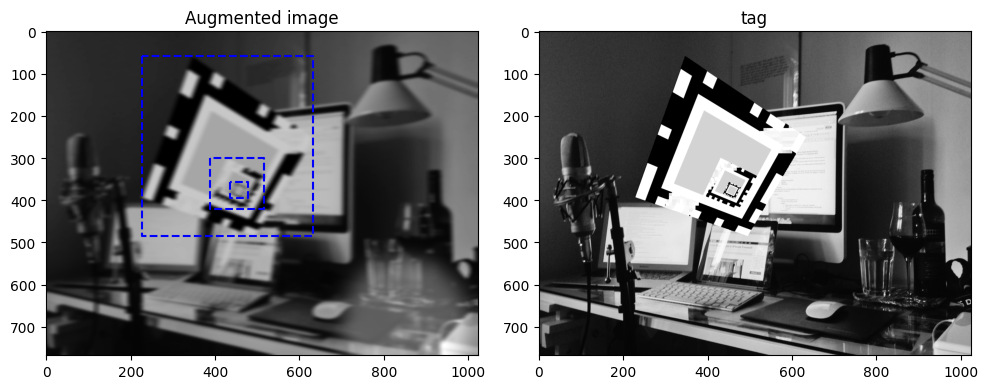

In [11]:
# Load configurations
config_path = 'config_img_with_tag.json'
with open(config_path, 'r') as file:
    data = json.load(file)

scales = data['scales'] # scales of the tags 
margins = data['margins'] # pixel size of tag margine from left top of the empty space
focal_length = data['focal_length']
ratio = data['ratio']
roll = data['roll']
pitch = data['pitch']
yaw = data['yaw']
radius = data['light_radius']
intensity = data['light_intensity']
ksize = data['ksize']
sigX = data['sigX']
mean = data['g_noise_mean']
sigma = random.randint(0, data['g_noise_sigma'])
motion_blur_size = random.randint(1, data['motion_blur_size'])
reflection = data['reflection']

imgpath = '../dataset/raw_imgs/test/00a36f96e31731c4.jpg'

ImgSyn = ImageSynthesizer(imgpath, scales, margins, focal_length, ratio, roll, pitch, yaw, radius, intensity, ksize, sigX, mean, sigma, motion_blur_size, reflection)
img_with_tag, homography_matrix, transformed_corners, corner_dict, percent = ImgSyn.create_tag()

aug1_prob = 0.5
if random.random() <= aug1_prob:
    aug1 = ImgSyn.apply_spot_light_effect(img_with_tag)
else:
    aug1 = img_with_tag

aug2_prob = 0.5
if random.random() <= aug2_prob:
    aug2 = ImgSyn.add_gaussian_blur(aug1)
else:
    aug2 = aug1

aug3_prob = 0.5
if random.random() <= aug2_prob:
    aug3 = ImgSyn.add_gaussian_noise(aug2)
else:
    aug3 = aug2

aug4_prob = 0.5
if random.random() <= aug4_prob:
    aug4 = ImgSyn.apply_motion_blur(aug3)
else:
    aug4 = aug3
# aug4 = img_with_tag

label = "label.json"
img_size = np.array([aug4.shape[0], aug4.shape[1]])
markers = []
for id, corners in corner_dict.items():
    corners_reshaped = corners.reshape(-1, 2)
    bbox_corners = ImgSyn.bounding_box(corners_reshaped)
    inner_corners = ImgSyn.extract_inner_corners(corners)
    marker = {
    "image_size": img_size.tolist(),
    "corners_outer": corners.tolist(),
    "corners_inner": inner_corners.tolist(),
    "bbox_corners": bbox_corners.tolist(),
    "tag_id": id,
    "reflection_area": percent}
    # if ImgSyn.is_bbox_large(bbox_corners, 50):
    markers.append(marker)

with open(label, 'w') as json_file:
    json.dump(markers, json_file, indent=4)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(aug4, cmap='gray')                                                                                                                                                       
# plt.plot(*np.append(transformed_corners, [transformed_corners[0]], axis=0).T, 'r-', marker='o', label='Quadrilateral')

for marker in markers:
    plt.plot(*np.append(marker["bbox_corners"], [marker["bbox_corners"][0]], axis=0).T, 'b--', label='Bounding Box')
plt.title('Augmented image')

plt.subplot(1, 2, 2)
plt.imshow(img_with_tag, cmap='gray')
plt.title('tag')

plt.tight_layout()
plt.show()

Create multiple synthetic images with tags

In [18]:
def gen_syn_img(source_dir, dest_dir, label_dir, json_path):
	with open(json_path, 'r') as file:
		data = json.load(file)

	scales = data['scales'] # scales of the tags 
	margins = data['margins'] # pixel size of tag margine from left top of the empty space
	focal_length = data['focal_length']
	ratio = data['ratio']
	roll = data['roll']
	pitch = data['pitch']
	yaw = data['yaw']
	radius = data['light_radius']
	intensity = data['light_intensity']
	ksize = data['ksize']
	sigX = data['sigX']
	mean = data['g_noise_mean']
	sigma = random.randint(0, data['g_noise_sigma'])
	motion_blur_size = random.randint(1, data['motion_blur_size'])
	reflection = data['reflection']

	if not os.path.exists(dest_dir):
		os.makedirs(dest_dir)
		
	if not os.path.exists(label_dir):
		os.makedirs(label_dir)
	
	for filename in os.listdir(source_dir):
		# Construct full file path
		file_path = os.path.join(source_dir, filename)
		
		if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
			dest_file_path = os.path.join(dest_dir, filename)
			if not os.path.exists(dest_file_path): 
				ImgSyn = ImageSynthesizer(file_path, scales, margins, focal_length, ratio, roll, pitch, yaw, radius, intensity, ksize, sigX, mean, sigma, motion_blur_size, reflection)
				img_with_tag, homography_matrix, transformed_corners, corner_dict, percent = ImgSyn.create_tag()
				bbox_corners =ImgSyn.bounding_box(transformed_corners)

				aug1_prob = 0.5
				if random.random() <= aug1_prob:
					aug1 = ImgSyn.apply_spot_light_effect(img_with_tag)
				else:
					aug1 = img_with_tag

				aug2_prob = 0.5
				if random.random() <= aug2_prob:
					aug2 = ImgSyn.add_gaussian_blur(aug1)
				else:
					aug2 = aug1

				aug3_prob = 0.5
				if random.random() <= aug3_prob:
					aug3 = ImgSyn.add_gaussian_noise(aug2)
				else:
					aug3 = aug2

				aug4_prob = 0.5
				if random.random() <= aug4_prob:
					aug4 = ImgSyn.apply_motion_blur(aug3)
				else:
					aug4 = aug3
				# aug4 = img_with_tag

				
				img_size = np.array([aug4.shape[0], aug4.shape[1]])
				markers = []
				for id, corners in corner_dict.items():
					corners_reshaped = corners.reshape(-1, 2)
					bbox_corners = ImgSyn.bounding_box(corners_reshaped)
					inner_corners = ImgSyn.extract_inner_corners(corners)
					marker = {
					"image_size": img_size.tolist(),
					"corners_outer": corners.tolist(),
					"corners_inner": inner_corners.tolist(),
					"bbox_corners": bbox_corners.tolist(),
					"tag_id": id,
					"reflection_area": percent}
					# if ImgSyn.is_bbox_large(bbox_corners, 50):
					markers.append(marker)

				cv2.imwrite(dest_file_path, aug4)
				print(f"Converted and saved {filename} to synthesized image.")
				
				label_file = os.path.splitext(filename)[0] + '.json'
				label_file_path = os.path.join(label_dir, label_file)
				with open(label_file_path, 'w') as json_file:
					json.dump(markers, json_file, indent=4)

In [20]:
# Define your source and destination directories
src_directory   = '../dataset/raw_imgs/test_thermal'
dst_directory   = '../dataset/nested2/images/test'
label_directory = '../dataset/nested2/labels/test'

gen_syn_img(src_directory, dst_directory, label_directory, 'config_img_with_tag.json')


Converted and saved video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz.jpg to synthesized image.
Converted and saved video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.jpg to synthesized image.
Converted and saved video-ZAtDSNuZZjkZFvMAo-frame-000126-zoY7B6uWtDpji8yhX.jpg to synthesized image.
Converted and saved video-ePoikf5LyTTfqchga-frame-000650-Qyt79x8SvYHboeyng.jpg to synthesized image.
Converted and saved video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQdmuhs64dh.jpg to synthesized image.
Converted and saved video-t3f7QC8hZr6zYXpEZ-frame-000180-KCbuiwR8D8fFGLcLJ.jpg to synthesized image.
Converted and saved video-SCiKdG3MqZfiE292B-frame-007995-atWouMTCk3mtQ8ura.jpg to synthesized image.
Converted and saved video-6tLtjdkv5K5BuhB37-frame-000063-rohYmg56KKKu8aTwA.jpg to synthesized image.
Converted and saved video-ePoikf5LyTTfqchga-frame-000637-KwCdaZv9oWkoZKjwA.jpg to synthesized image.
Converted and saved video-5RSrbWYu9eokv5bvR-frame-000145-BRybpeJn2pv8gj3Fe.jpg to synthesiz